<a href="https://colab.research.google.com/github/Ademkck/Pneumonia-detection-using-cnn/blob/main/Pneumoniadetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [22]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [23]:
train = get_training_data("/content/drive/MyDrive/chest_xray/train")
test = get_training_data("/content/drive/MyDrive/chest_xray/test")
val = get_training_data("/content/drive/MyDrive/chest_xray/val")

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [24]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3892
Normal: 1342
Pneumonia - Normal: 2550


PNEUMONIA


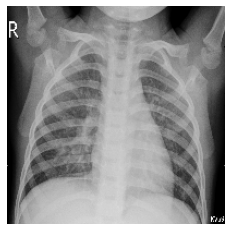

In [25]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

Text(0.5, 1.0, 'NORMAL')

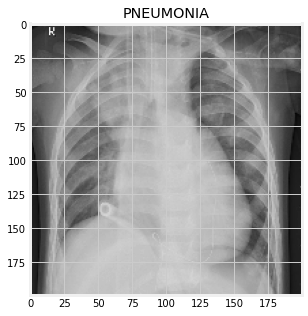

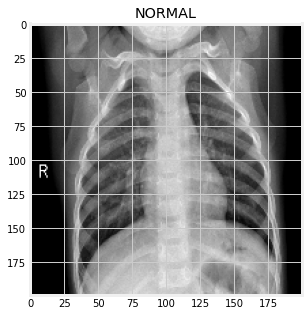

In [28]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [29]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [30]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [32]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 100, 100, 256)    0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 100, 100, 256)    400       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)     

In [34]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
376/376 [==============================] - 56s 143ms/step - loss: 0.5993 - acc: 0.7217 - val_loss: 0.6771 - val_acc: 0.7383
Epoch 2/15
376/376 [==============================] - 49s 131ms/step - loss: 0.4635 - acc: 0.7800 - val_loss: 0.3134 - val_acc: 0.9021
Epoch 3/15
376/376 [==============================] - 50s 132ms/step - loss: 0.3965 - acc: 0.8138 - val_loss: 0.3005 - val_acc: 0.8872
Epoch 4/15
376/376 [==============================] - 49s 131ms/step - loss: 0.3690 - acc: 0.8319 - val_loss: 0.2709 - val_acc: 0.9032
Epoch 5/15
376/376 [==============================] - 49s 132ms/step - loss: 0.3480 - acc: 0.8494 - val_loss: 0.2723 - val_acc: 0.9202
Epoch 6/15
376/376 [==============================] - 50s 132ms/step - loss: 0.3250 - acc: 0.8627 - val_loss: 0.2413 - val_acc: 0.9032
Epoch 7/15
376/376 [==============================] - 49s 131ms/step - loss: 0.3050 - acc: 0.8688 - val_loss: 0.2201 - val_acc: 0.9213
Epoch 8/15
376/376 [==============================] - 4

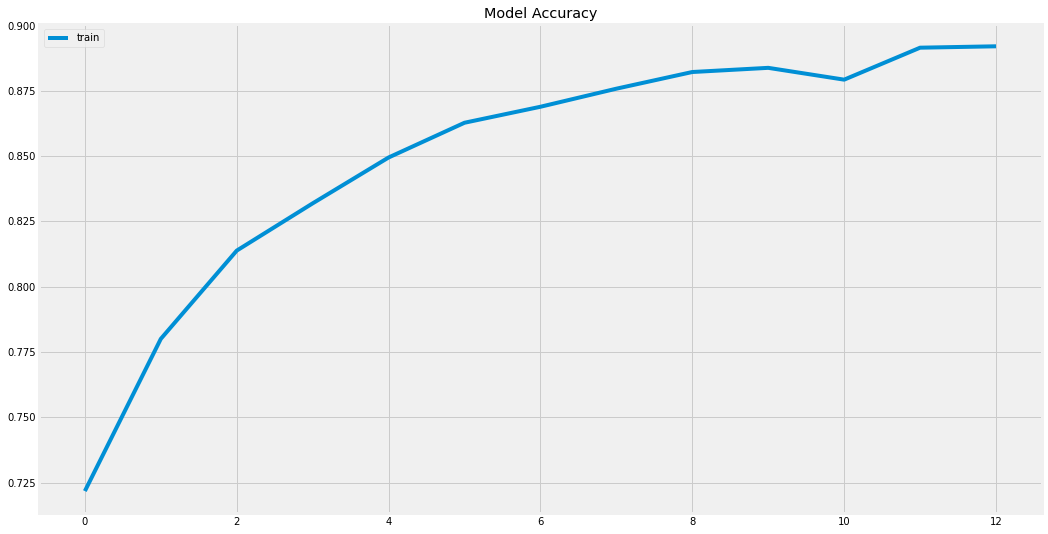

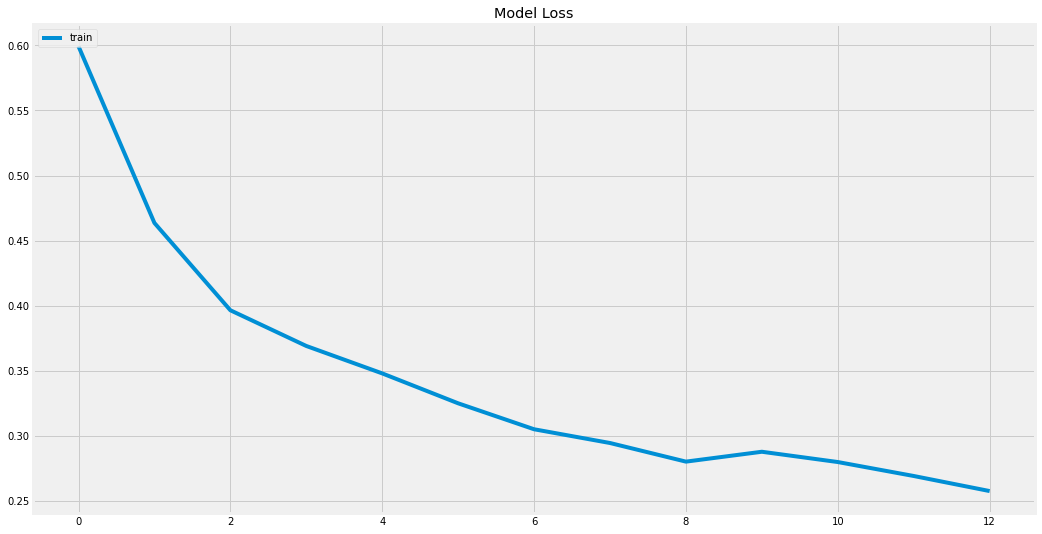

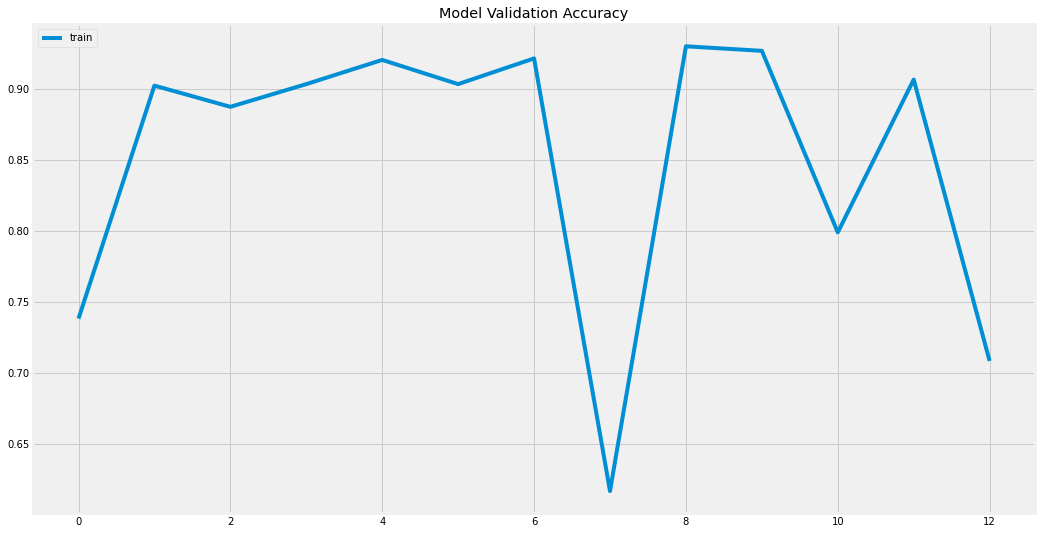

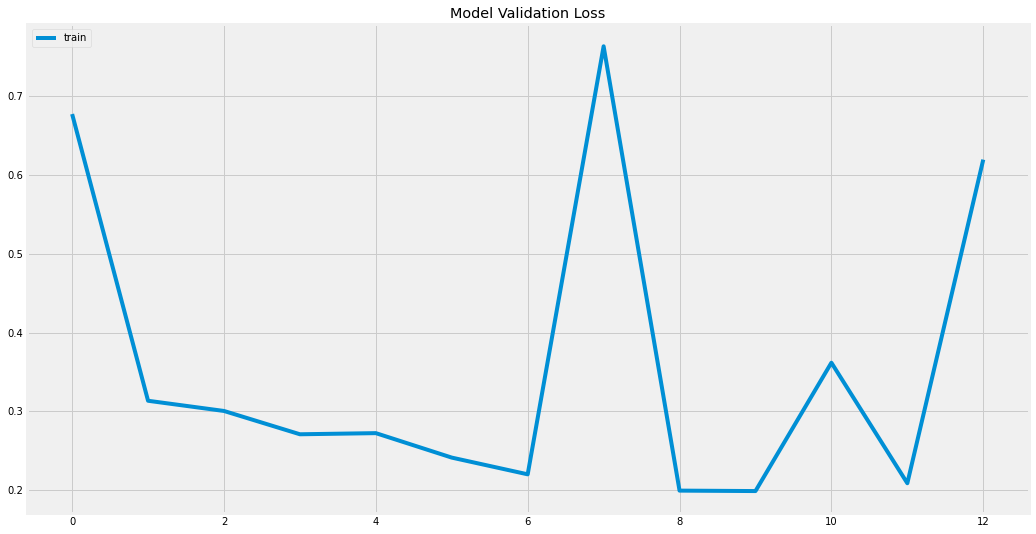

In [35]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [36]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

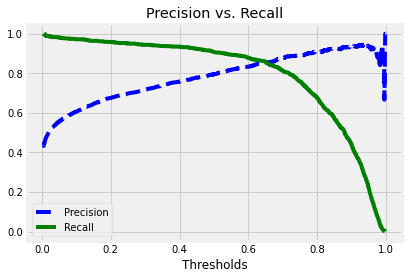

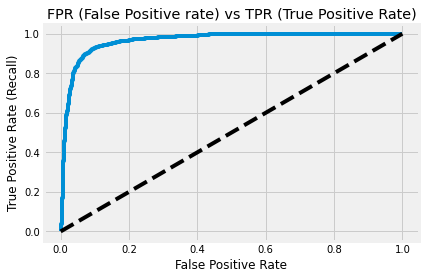

In [37]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [38]:
predictions = model.predict(X_test)

In [39]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [40]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9148936170212766
Precision on testing set: 0.9142011834319527
Recall on testing set: 0.8131578947368421


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

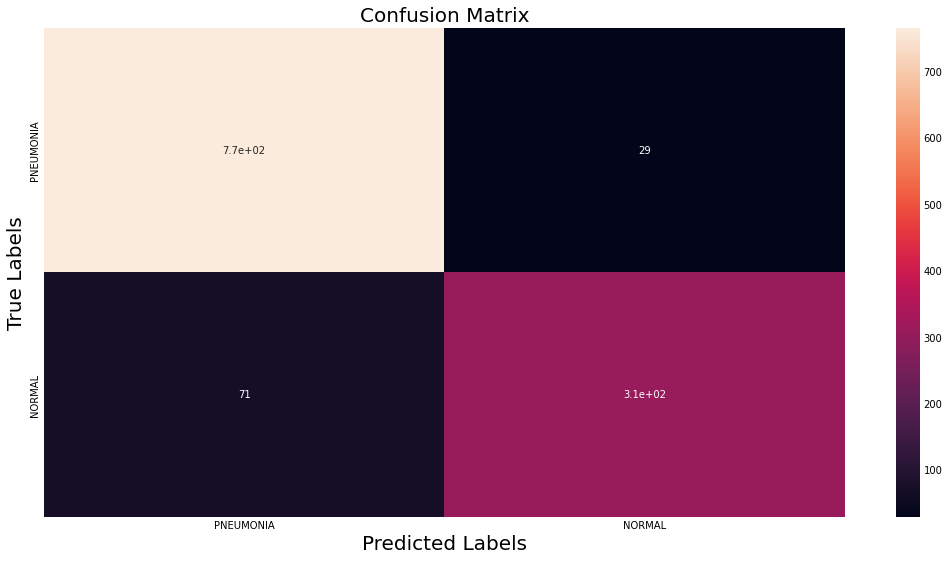

In [41]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

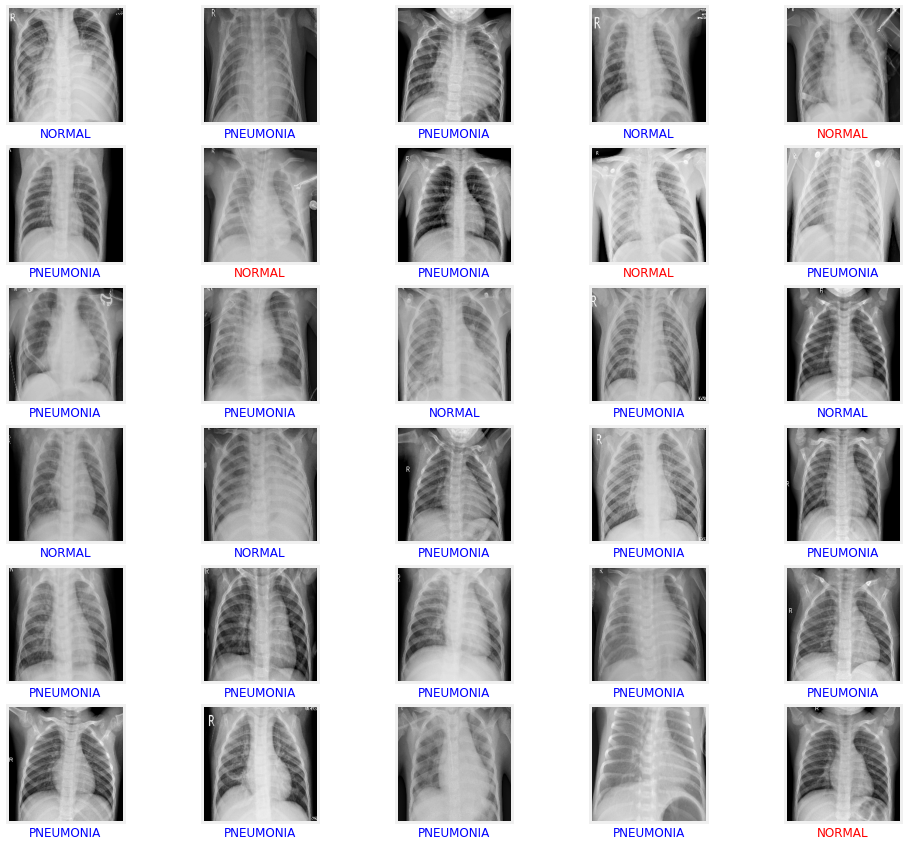

In [44]:
plt.figure(figsize=(15,15))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()